In [1]:
from qiskit import *
import numpy as np
from qiskit.tools.visualization import plot_histogram

In [2]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    circuit.barrier()
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    circuit.barrier()
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

In [3]:
def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.barrier()
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

In [4]:
#number of bits for search
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, -2, 3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Define quantum circuit with above registers
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

In [5]:
input_state(grover,f_in,f_out,n)

In [6]:
T = 1
for t in range(T):
    # Apply T full iterations
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

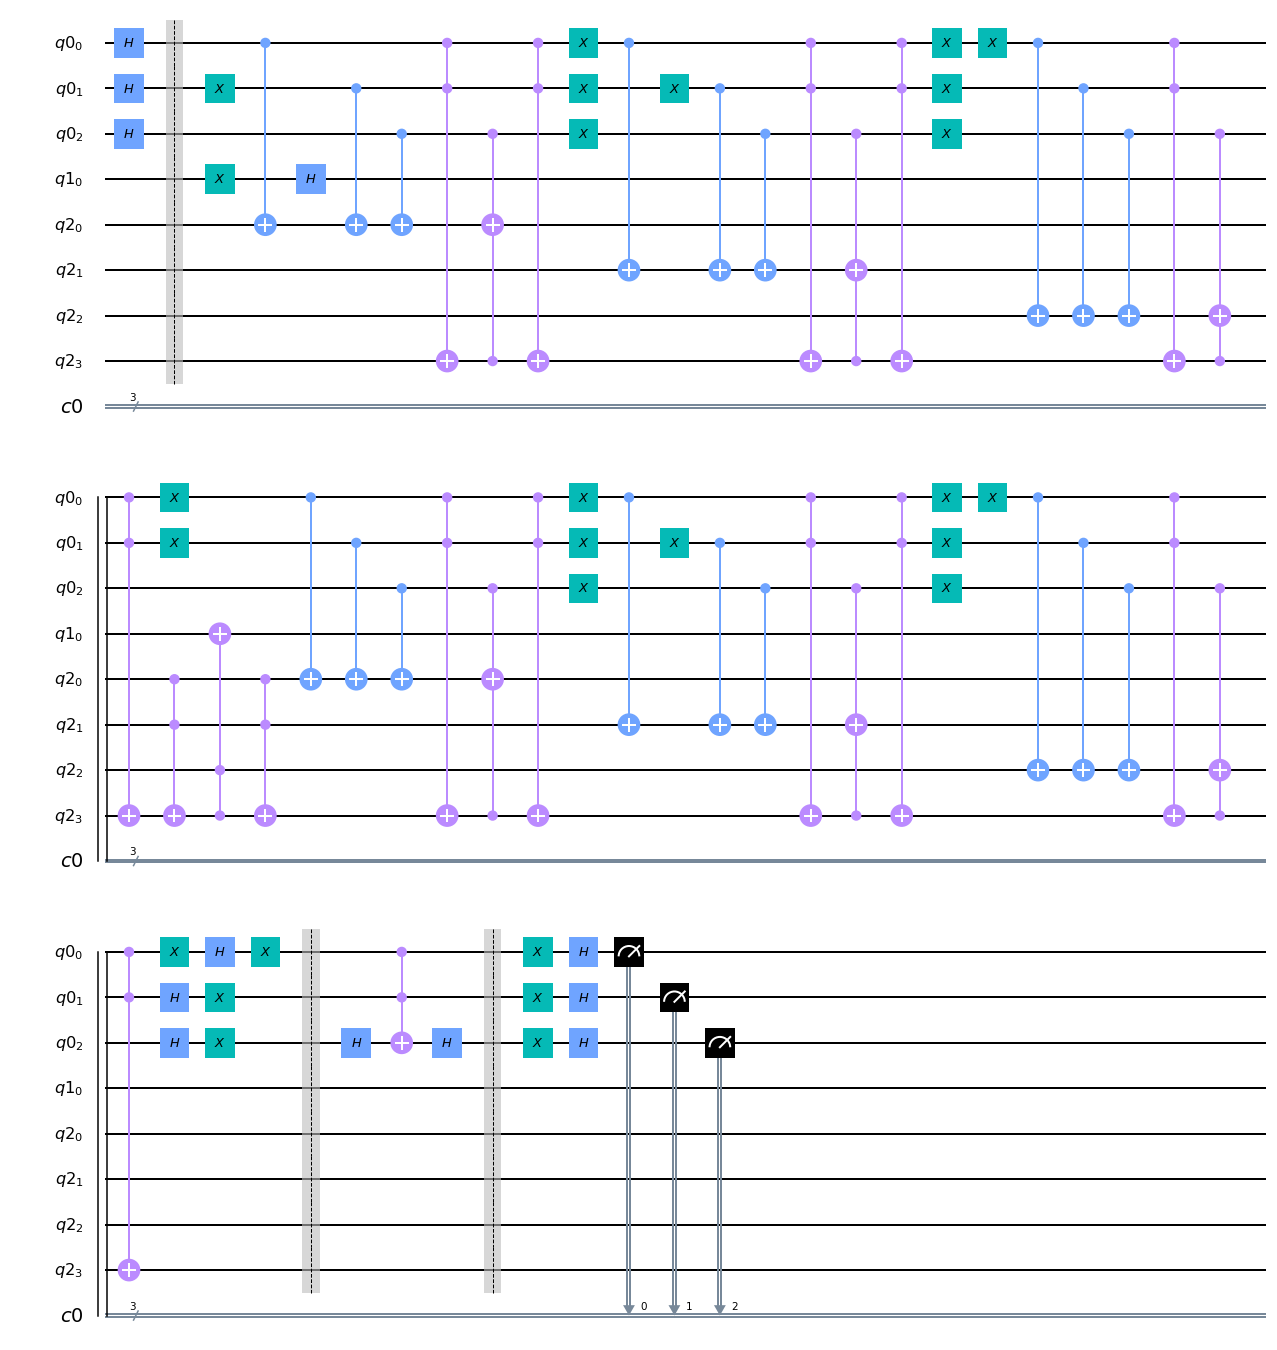

In [7]:
# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

    
grover.draw(output='mpl')

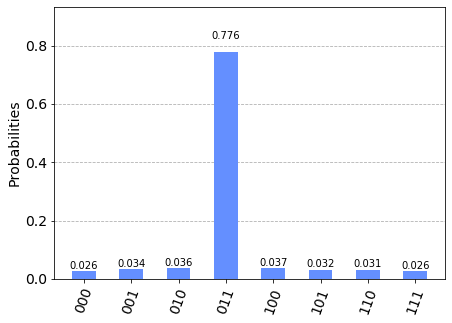

In [8]:
# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute(grover, backend=backend, shots=1024)
sres = job.result()

# Get counts and plot histogram
counts = sres.get_counts(grover)
plot_histogram(counts)

In [9]:
#running on a real quantum device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(grover, backend = qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

/home/nico/.local/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


Job Status: job has successfully run


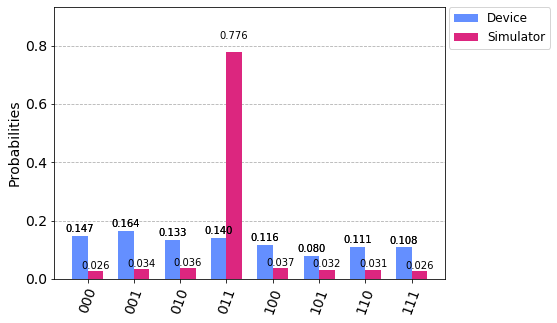

In [10]:
#plotting the results of the real computation
qres = job.result()
counts = qres.get_counts()
#print('The run counts are:', counts)
plot_histogram([qres.get_counts(grover), sres.get_counts(grover)], legend=['Device', 'Simulator'])

Job Status: job has successfully run


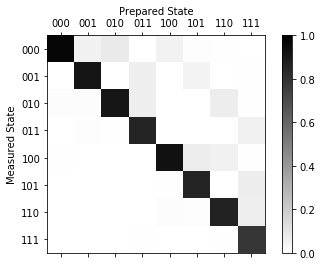

In [11]:
#noise mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr = grover.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

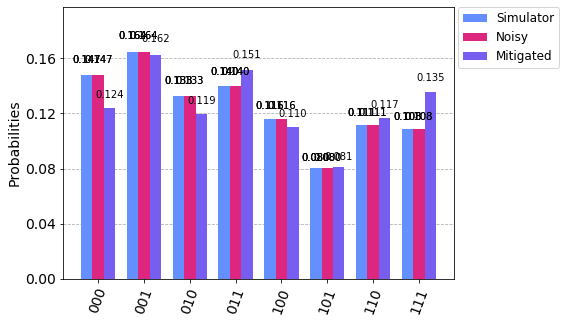

In [12]:
#plotting the sim vs noisy results vs mitigated results
qcounts = qres.get_counts(grover)
mitcounts = mitres.get_counts(grover)
plot_histogram([counts, qcounts, mitcounts], legend = ['Simulator', 'Noisy', 'Mitigated'])